## Import Modules

In [1]:
import os
import re
import collections
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import heapq
import sortedcontainers

from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Directories, Files, Embedder

In [2]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')
data_dir = os.getenv("DATA_DIR")
print(data_dir)

/proj/sbaruah/data


## Attribute-Types

In [3]:
attributes_file = os.path.join(data_dir, "mica-character-attribute-extraction/passage-attributes.csv")
attributes_df = pd.read_csv(attributes_file, index_col=None)
attribute_pattern = re.compile(r"\d+\.\s+\(([^,]+),([^,]+),([^,\)]+)\)")
attributes = []

for _, row in attributes_df.iterrows():
    text = row["attributes"]
    for i, match in enumerate(re.finditer(attribute_pattern, text)):
        character, attribute_type, attribute_value = (match.group(1).strip(), match.group(2).strip().lower(), 
                                                      match.group(3).strip().lower())
        attribute_type = re.sub(r"^((attribute)|(trait))\-type\:\s+", "", attribute_type).strip('"').strip()
        if attribute_type:
            attributes.append((attribute_type, attribute_value))

all_attribute_types = [at for at, _ in attributes]
attribute_types = sorted(set(all_attribute_types))
attribute_type_distribution = sorted(collections.Counter(all_attribute_types).items(), key=lambda item: item[1], 
                                     reverse=True)
attribute_type_distribution_dict = dict(attribute_type_distribution)
print(f"{len(attributes)} attributes")
print(f"{len(attribute_type_distribution)} unique attribute-types")
print()

print(f"top-10 attribute-types =>")
cumulative_per = 0
for i, (at, count) in enumerate(attribute_type_distribution[:10]):
    per = 100 * count / len(attributes)
    cumulative_per += per
    print(f"{i + 1:2d}. {at:30s} {count:4d}/{len(attributes)} {per:5.2f}% {cumulative_per:5.2f}%")
print()

for n in range(2, 11):
    count = sum(1 for _, count in attribute_type_distribution if count >= n)
    print(f"{count:3d} attribute-types occurred atleast {n} times")

attribute_type_distribution_file = os.path.join(data_dir, 
                                                "mica-character-attribute-extraction/attribute-type-distribution.txt")
with open(attribute_type_distribution_file, "w") as fw:
    for at in attribute_types:
        count = attribute_type_distribution_dict[at]
        fw.write(f"{at:30s}\t\t{count}\n")

14383 attributes
3232 unique attribute-types

top-10 attribute-types =>
 1. action                         2660/14383 18.49% 18.49%
 2. behavior                        618/14383  4.30% 22.79%
 3. activity                        480/14383  3.34% 26.13%
 4. location                        390/14383  2.71% 28.84%
 5. emotion                         337/14383  2.34% 31.18%
 6. state                           274/14383  1.91% 33.09%
 7. position                        219/14383  1.52% 34.61%
 8. appearance                      190/14383  1.32% 35.93%
 9. demeanor                        146/14383  1.02% 36.95%
10. emotional state                 146/14383  1.02% 37.96%

866 attribute-types occurred atleast 2 times
506 attribute-types occurred atleast 3 times
359 attribute-types occurred atleast 4 times
283 attribute-types occurred atleast 5 times
229 attribute-types occurred atleast 6 times
193 attribute-types occurred atleast 7 times
170 attribute-types occurred atleast 8 times
150 attribut

## Encode attribute-types

In [4]:
keywords = [at for at in attribute_types if attribute_type_distribution_dict[at] > 1]
print(f"{len(keywords)} keywords")

866 keywords


In [5]:
# encode keywords
keyword_embeddings = embedder.encode(keywords)
keyword_embeddings = keyword_embeddings / np.linalg.norm(keyword_embeddings, axis=1, keepdims=True)

# find similarity between keywords
similarity = np.matmul(keyword_embeddings, keyword_embeddings.T)
similarity = (similarity - similarity.min())/(similarity.max() - similarity.min())
distance = 1 - similarity
np.fill_diagonal(distance, 0)

# print min, max
print(f"distance [{distance.min():.4f}, {distance.max():.4f}]")
print(f"similarity [{similarity.min():.4f}, {similarity.max():.4f}]")

distance [0.0000, 1.0000]
similarity [0.0000, 1.0000]


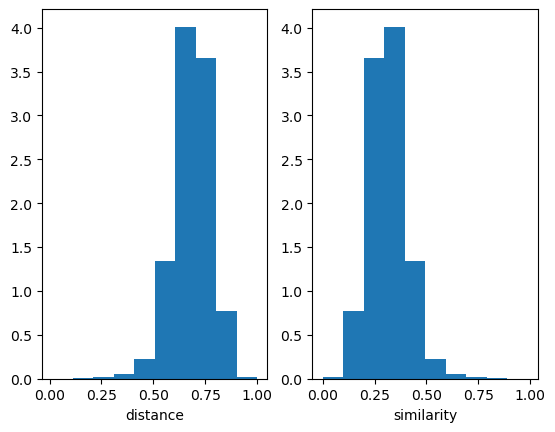

In [6]:
_distance = np.triu(distance + 1e-23, k=1)
distance_values = _distance[_distance > 0]
_similarity = np.triu(similarity + 1e-23, k=1)
similarity_values = _similarity[_similarity > 0]

plt.subplot(1, 2, 1)
plt.hist(distance_values, bins=10, density=True)
plt.xlabel("distance")

plt.subplot(1, 2, 2)
plt.hist(similarity_values, bins=10, density=True)
plt.xlabel("similarity")

plt.show()

## Clustering

In [7]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    cluster_model = AgglomerativeClustering(metric="cosine", linkage="average", distance_threshold=threshold, 
                                            n_clusters=None)
        ter_model.fit(keyword_embeddings)

    clusters_dict = collections.defaultdict(set)
    for i, cluster_label in enumerate(cluster_model.labels_):
        clusters_dict[cluster_label].add(i)
    clusters = list(clusters_dict.values())
    clusters = sorted(clusters, key=lambda cluster: len(cluster), reverse=True)

    score = silhouette_score(keyword_embeddings, cluster_model.labels_, metric="cosine")

    n_singletons = sum(len(cluster) == 1 for cluster in clusters)
    items_in_singletons = [cluster.pop() for cluster in clusters if len(cluster) == 1]
    clustered_items = [i for i in range(len(keywords)) if i not in items_in_singletons]
    _embeddings = keyword_embeddings[clustered_items]
    _labels = [label for i, label in enumerate(cluster_model.labels_) if i in clustered_items]
    score_without_singletons = silhouette_score(_embeddings, _labels, metric="cosine")

    print(f"threshold = {threshold}, {len(clusters):3d} clusters, {n_singletons:3d} singleton-clusters, "
          f"silhouette-score = {score:7.4f}, silhouette-score-w/o-singletons = {score_without_singletons:7.4f}")
    # print()

    # clusters_file = os.path.join(data_dir, 
    #                              f"mica-character-attribute-extraction/attribute-type-clusters-{threshold}.txt")
    # with open(clusters_file, "w") as fw:
    #     fw.write(f"clusters farther than threshold distance apart are not merged\n")
    #     fw.write(f"threshold = {threshold}\n\n")
    #     fw.write(f"{len(clusters)} clusters\n")
    #     for n in range(2, 6):
    #         count = sum(len(cluster) >= n for cluster in clusters)
    #         fw.write(f"{count} clusters have atleast {n} elements\n")
    #     fw.write("\n\n======================================================\n\n")
    #     for i, cluster in enumerate(clusters):
    #         fw.write(f"Cluster {i + 1}/{len(clusters)}, n = {len(cluster)}\n")
    #         cluster_elements = sorted(cluster, key=lambda i: attribute_type_distribution_dict[attribute_types[i]], 
    #                                   reverse=True)
    #         for i in cluster_elements:
    #             element = attribute_types[i]
    #             count = attribute_type_distribution_dict[element]
    #             sign = "**" if count >= 10 else "*" if count > 1 else ""
    #             fw.write(f"\t{sign:3s} {element}\n")
    #         fw.write("\n")

threshold = 0.1, 797 clusters, 733 singleton-clusters, silhouette-score =  0.1190, silhouette-score-w/o-singletons =  0.8391
threshold = 0.2, 734 clusters, 629 singleton-clusters, silhouette-score =  0.1652, silhouette-score-w/o-singletons =  0.6747
threshold = 0.3, 617 clusters, 463 singleton-clusters, silhouette-score =  0.1977, silhouette-score-w/o-singletons =  0.4955
threshold = 0.4, 455 clusters, 275 singleton-clusters, silhouette-score =  0.2198, silhouette-score-w/o-singletons =  0.3640
threshold = 0.5, 306 clusters, 113 singleton-clusters, silhouette-score =  0.2238, silhouette-score-w/o-singletons =  0.2771
threshold = 0.6, 167 clusters,  34 singleton-clusters, silhouette-score =  0.1763, silhouette-score-w/o-singletons =  0.1915
threshold = 0.7,  62 clusters,  10 singleton-clusters, silhouette-score =  0.0766, silhouette-score-w/o-singletons =  0.0853
threshold = 0.8,  13 clusters,   4 singleton-clusters, silhouette-score = -0.0102, silhouette-score-w/o-singletons =  0.0029


## Cluster Representative

In [8]:
threshold = 0.5
cluster_model = AgglomerativeClustering(metric="cosine", linkage="average", distance_threshold=threshold, 
                                        n_clusters=None)
cluster_model.fit(keyword_embeddings)

clusters_dict = collections.defaultdict(set)
for i, cluster_label in enumerate(cluster_model.labels_):
    clusters_dict[cluster_label].add(i)
clusters = list(clusters_dict.values())
clusters = sorted(clusters, key=lambda cluster: len(cluster), reverse=True)

clusters = [sorted(cluster, key=lambda i: attribute_type_distribution_dict[keywords[i]], reverse=True)
            for cluster in clusters]
print(f"threshold = {threshold}, {len(clusters)} clusters")

threshold = 0.5, 306 clusters


In [9]:
def representative_keyword(cluster):
    _distance = distance[cluster][:,cluster]
    _distance_sum = _distance.sum(axis=1)
    i = _distance_sum.argmin()
    return cluster[i]

n = 50
representative_file = os.path.join(data_dir, 
                                   "mica-character-attribute-extraction/attribute-cluster-representatives.txt")

with open(representative_file, "w") as fw:
    for i, cluster in enumerate(clusters[:n]):
        r = representative_keyword(cluster)
        repr_str = keywords[r]
        fw.write(f"Cluster {i + 1}/{len(clusters)}, n = {len(cluster)}\n")
        fw.write(f"Representative = {repr_str}\n")
        for j in cluster:
            element = keywords[j]
            count = attribute_type_distribution_dict[element]
            sign = "**" if count >= 10 else "*" if count > 1 else ""
            fw.write(f"\t{sign:3s} {element}\n")
        fw.write("\n")

## Cluster Representatives

In [11]:
r_arr = [representative_keyword(cluster) for cluster in clusters]
repr_embeddings = keyword_embeddings[r_arr]
repr_keywords = [keywords[i] for i in r_arr]

In [18]:
threshold = 0.5
cluster_model = AgglomerativeClustering(n_clusters=None, metric="cosine", linkage="average", 
                                        distance_threshold=threshold)
cluster_model.fit(repr_embeddings)

clusters_dict = collections.defaultdict(set)
for i, cluster_label in enumerate(cluster_model.labels_):
    clusters_dict[cluster_label].add(i)
clusters = list(clusters_dict.values())
clusters = sorted(clusters, key=lambda cluster: len(cluster), reverse=True)
print(f"{len(clusters)} clusters")

223 clusters


In [20]:
repr_clusters_file = os.path.join(data_dir, 
                                  f"mica-character-attribute-extraction/attribute-type-repr-clusters-{threshold}.txt")
with open(repr_clusters_file, "w") as fw:
    for i, cluster in enumerate(clusters):
        fw.write(f"Cluster {i + 1}/{len(clusters)}, n = {len(cluster)}\n")
        cluster_elements = sorted(cluster, key=lambda i: attribute_type_distribution_dict[repr_keywords[i]], 
                                    reverse=True)
        for i in cluster_elements:
            element = repr_keywords[i]
            count = attribute_type_distribution_dict[element]
            sign = "**" if count >= 10 else "*" if count > 1 else ""
            fw.write(f"\t{sign:3s} {element}\n")
        fw.write("\n")

## Sample for Self-Annotation

In [14]:
passage_file = os.path.join(data_dir, "mica-character-attribute-extraction/passage-attributes.csv")
passage_df = pd.read_csv(passage_file, index_col=None)
print(passage_df.shape)
print(passage_df.columns)

(2000, 6)
Index(['story-id', 'passage-id', 'passage', 'characters', 'attributes',
       'completions'],
      dtype='object')


In [21]:
books_df = passage_df.loc[passage_df["story-id"].str.match("\d+$")].sample(50, random_state=99)
scripts_df = passage_df.loc[~passage_df["story-id"].str.match("\d+$")].sample(50, random_state=99)
self_df = pd.concat([books_df, scripts_df])
self_df = self_df.sample(frac=1)

self_file = os.path.join(data_dir, "mica-character-attribute-extraction/self-annotation-exercise.txt")
with open(self_file, "w") as fw:
    for _, row in self_df.iterrows():
        passage = row["passage"]
        attributes = "\t" + row["attributes"].replace("\n", "\n\t")
        fw.write(f"{passage}\n\nllm-labels\n{attributes}\n\nself-labels\n\n")
        fw.write("================================================================================================\n\n")

In [17]:
def cluster_str(cluster, keywords, truncate = None, include_count = False) -> str:
    parent = keywords[cluster.parent]
    items = [keywords[i] for i in cluster.items if i != cluster.parent]
    if len(cluster) == 1:
        return f"{{{parent}}}"
    elif truncate is None:
        items_str = ", ".join(items)
    else:
        items_str = ", ".join(items[:truncate])
    if include_count:
        desc = f"{{[{parent}] {items_str} <n={len(cluster)}>}}"
    else:
        desc = f"{{[{parent}] {items_str}}}"
    return desc

class Cluster:

    items_str = None

    def __init__(self, items, parent) -> None:
        self.items = items
        self.parent = parent
    
    def __eq__(self, cluster: "Cluster") -> bool:
        return self.items == cluster.items

    def __len__(self) -> int:
        return len(self.items)

    def __repr__(self) -> str:
        if len(self) > 10:
            return cluster_str(self, self.items_str, truncate=10, include_count=True)
        else:
            return cluster_str(self, self.items_str)

class ClusterPair:

    def __init__(self, cluster_a, cluster_b, distance) -> None:
        self.cluster_a = cluster_a
        self.cluster_b = cluster_b
        self.distance = distance
    
    def __lt__(self, pair: "ClusterPair") -> bool:
        return self.distance < pair.distance

    def __repr__(self) -> str:
        return f"({self.cluster_a}, {self.cluster_b}, {self.distance:.4f})"

def find_representative(items, distance) -> int:
    item_distance = distance[items][:,items]
    item_score = item_distance.sum(axis=1)
    i = item_score.argmax()
    return items[i]

def merge_clusters(cluster_a, cluster_b, distance) -> Cluster:
    merged_items = cluster_a.items + cluster_b.items
    parent = find_representative(merged_items, distance)
    merged_cluster = Cluster(merged_items, parent)
    return merged_cluster

In [5]:
verbose = True

In [22]:
Cluster.items_str = keywords

In [20]:
# initialize
clusters = [Cluster([i], i) for i in range(len(keywords))]
cluster_pairs = []
for i in range(len(keywords) - 1):
    for j in range(i + 1, len(keywords)):
        cluster_pair = ClusterPair(clusters[i], clusters[j], distance[i, j])
        cluster_pairs.append(cluster_pair)
taxonomy = np.zeros((len(keywords), len(keywords)), dtype=int)

In [23]:
n = 10
cluster_pairs = sorted(cluster_pairs, key=lambda pair: pair.distance)
for i, pair in enumerate(cluster_pairs[:n]):
    print(f"{i + 1:3d}. {pair})")

  1. ({leisure activity}, {leisure-activity}, 0.0090))
  2. ({sensory action}, {sensory-action}, 0.0104))
  3. ({financial planning}, {financial-planning}, 0.0105))
  4. ({speech attribute}, {speech-attribute}, 0.0112))
  5. ({marital status}, {marital-status}, 0.0113))
  6. ({clothing condition}, {clothing-condition}, 0.0117))
  7. ({physical limitation}, {physical-limitation}, 0.0123))
  8. ({physiological response}, {physiological-response}, 0.0124))
  9. ({financial status}, {financial-status}, 0.0125))
 10. ({physical trait}, {physical-trait}, 0.0129))


In [24]:
heapq.heapify(cluster_pairs)

In [25]:
cluster_pairs[0]

({leisure activity}, {leisure-activity}, 0.0090)

In [27]:
pairs = sortedcontainers.SortedList()
pairs.update(cluster_pairs)

In [30]:
pairs[0]

({leisure activity}, {leisure-activity}, 0.0090)

In [31]:
pair = pairs.pop(0)
pair

({leisure activity}, {leisure-activity}, 0.0090)

In [77]:
# agglomerative clustering
while len(clusters) > 1:

    # find cluster pair (cluster_a, cluster_b) with maximum similarity
    i = 0
    for j in range(1, len(cluster_similarity_pairs)):
        if cluster_similarity_pairs[j].similarity > cluster_similarity_pairs[i].similarity:
            i = j
    cluster_a, cluster_b = cluster_similarity_pairs[i].cluster_a, cluster_similarity_pairs[i].cluster_b
    
    # delete cluster a and cluster b
    clusters = [cluster for cluster in clusters if cluster != cluster_a or cluster != cluster_b]

    # merge cluster a and cluster b
    merged_cluster = merge_clusters(cluster_a, cluster_b, similarity)

    # add the merged cluster
    clusters.append(merged_cluster)

    # delete the cluster pair with max similarity
    cluster_similarity_pairs = cluster_similarity_pairs[:i] + cluster_similarity_pairs[i + 1:]

    # update existing cluster similarity pairs
    for pair in cluster_similarity_pairs:
        if pair.cluster_a == cluster_a or pair.cluster_a == cluster_b:
            pair.cluster_a = merged_cluster
            pair.similarity = similarity[pair.cluster_b.parent, merged_cluster.parent]
        elif pair.cluster_b == cluster_a or pair.cluster_b == cluster_b:
            pair.cluster_b = merged_cluster
            pair.similarity = similarity[pair.cluster_a.parent, merged_cluster.parent]

    # update taxonomy tree
    parent, parent_a, parent_b = merged_cluster.parent, cluster_a.parent, cluster_b.parent
    if parent == parent_a:
        taxonomy[parent, parent_b] = 1
    elif parent == parent_b:
        taxonomy[parent, parent_a] = 1
    else:
        i = np.nonzero(taxonomy[:, parent])[0][0]
        for j in np.nonzero(taxonomy[parent])[0]:
            taxonomy[parent, j] = 0
            taxonomy[i, j] = 1
        taxonomy[parent, parent_a] = 1
        taxonomy[parent, parent_b] = 1
    
    # logging
    if verbose:
        cluster_a_str = cluster_str(cluster_a, keywords, truncate=10, include_count=True)
        cluster_b_str = cluster_str(cluster_b, keywords, truncate=10, include_count=True)
        print(f"merge >\n\t{cluster_a_str}\n\t{cluster_b_str}")

merge >
	{leisure activity}
	{leisure-activity}
merge >
	{sensory action}
	{sensory-action}
merge >
	{financial planning}
	{financial-planning}
merge >
	{speech attribute}
	{speech-attribute}


KeyboardInterrupt: 